# LoadGaugesNewport.ipynb

## Load gauge time series from netCDF file

Under development for the [Cascadia CoPes Hub](https://cascadiacopeshub.org/) project, supported by NSF.

This notebook uses a datafile containing gauge time series the 36 ground motions developed for the Cascadia CoPes Hub,
at gauge locations in Newport, OR.


This has data for the 18 "buried rupture" events at a set of gauges in Newport, OR, for a 2-hour tsunami simulation.

The gauge locations are shown in the map at the top of [this page](https://depts.washington.edu/ptha/CopesHubTsunamis/geoclaw_runs/sites/seaside/multirun2_hyak_2024-11-11/geoclaw_plots/), or you can download the [SeasideGauges.kml](https://depts.washington.edu/ptha/CopesHubTsunamis/geoclaw_runs/sites/seaside/multirun2_hyak_2024-11-11/geoclaw_plots/SeasideGauges.kml) and open it in Google Earth.

In [1]:
%matplotlib inline

In [2]:
from pylab import *
import xarray
import os,sys
from pathlib import Path
from importlib import reload
from clawpack.clawutil.util import fullpath_import

In [3]:
sys.path.insert(0,'../../src')
import CHTuser

In [4]:
from CHTuser import CHTtools

## Use this function to read in a file

This example uses the data file available at ???
|
To run this notebook, download this file and make sure `ncfile` includes the path to this file if it is not in the same directory as this notebook.

In [5]:
CHTdata = Path('/Users/rjl/CHTdata')
#CHTdata = Path('/home/jupyter/Community/geoclaw/CHTdata')  # on Design Safe Jupyter Hub

ncfile = Path(CHTdata, 'Newport/Newport_gauges_36events_251204.nc')

In [6]:
gauge_x, gauge_y, gauge_t, gauge_vals = CHTtools.read_allgauges_nc(ncfile)

Trying to read /Users/rjl/CHTdata/Newport/Newport_gauges_36events_251204.nc  ...
All gauge output for Newport
Loaded 2881 times from t = 0.0 to 14400.0 sec at 78 gauges
   for 36 events, with qois ['h' 'u' 'v' 'eta' 'level']
print gauge_vals.coords for more info


### Examine the data:

In [7]:
gauge_vals

<xarray.DataArray (time: 2881, gaugeno: 78, qoi: 5, event: 36)> Size: 162MB
[40449240 values with dtype=float32]
Coordinates:
  * time     (time) float32 12kB 0.0 5.0 10.0 ... 1.439e+04 1.44e+04 1.44e+04
  * gaugeno  (gaugeno) int32 312B 1001 1002 1003 1004 ... 1075 1076 1077 1078
  * qoi      (qoi) <U5 100B 'h' 'u' 'v' 'eta' 'level'
  * event    (event) <U5 720B 'BL10D' 'BL10M' 'BL10S' ... 'FR16M' 'FR16S'

## Convert to an xarray dataset

`gauge_vals` is one large 4-dimensional array indexed by the quantity of interest `qoi` as well as by `event`, `gaugeno`, and `time`.
For most purposes it's easiest  to convert is to an `xarray.Dataset`, a collection of DataArray's split up by the qoi:

In [8]:
ds = gauge_vals.to_dataset(dim='qoi')

In [9]:
ds

<xarray.Dataset> Size: 162MB
Dimensions:  (time: 2881, gaugeno: 78, event: 36)
Coordinates:
  * time     (time) float32 12kB 0.0 5.0 10.0 ... 1.439e+04 1.44e+04 1.44e+04
  * gaugeno  (gaugeno) int32 312B 1001 1002 1003 1004 ... 1075 1076 1077 1078
  * event    (event) <U5 720B 'BL10D' 'BL10M' 'BL10S' ... 'FR16M' 'FR16S'
Data variables:
    h        (time, gaugeno, event) float32 32MB ...
    u        (time, gaugeno, event) float32 32MB ...
    v        (time, gaugeno, event) float32 32MB ...
    eta      (time, gaugeno, event) float32 32MB ...
    level    (time, gaugeno, event) float32 32MB ...

In [10]:
print('\nEvents: \n',ds.coords['event'].data)
print('\nGauges: \n',ds.coords['gaugeno'].data)
print(f'\nAt {len(ds.coords['time'])} times up to {array(ds.coords['time']).max()/3600} hours\n')


Events: 
 ['BL10D' 'BL10M' 'BL10S' 'BL13D' 'BL13M' 'BL13S' 'BL16D' 'BL16M' 'BL16S'
 'BR10D' 'BR10M' 'BR10S' 'BR13D' 'BR13M' 'BR13S' 'BR16D' 'BR16M' 'BR16S'
 'FL10D' 'FL10M' 'FL10S' 'FL13D' 'FL13M' 'FL13S' 'FL16D' 'FL16M' 'FL16S'
 'FR10D' 'FR10M' 'FR10S' 'FR13D' 'FR13M' 'FR13S' 'FR16D' 'FR16M' 'FR16S']

Gauges: 
 [1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014
 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028
 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042
 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056
 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069 1070
 1071 1072 1073 1074 1075 1076 1077 1078]

At 2881 times up to 4.0 hours



## Plot gauge locations

Here's a way to make an interactive folium map showing one or more gauge locations...


In [11]:
def folium_plot_gauge(gaugenos, center=None, zoom_start=13):
    import folium
    import numpy as np

    if not isinstance(gaugenos, (list, tuple, np.ndarray)):
        # If it's not a list, wrap it in one
        gaugenos = [gaugenos]
       
    #tiles = 'OpenStreetMap'  # default tiles
    tiles = 'OpenTopoMap'   # show contours
    
    m = None

    for gaugeno in gaugenos:
 
        xg = gauge_x.sel(gaugeno=gaugeno)
        yg = gauge_y.sel(gaugeno=gaugeno)
        #print(f'Gauge %i is at (%.5f, %.5f)' % (gaugeno, xg, yg))

        if m is None:
            if center is None:
                location=(yg, xg)
            elif isinstance(center,int):
                xgc = gauge_x.sel(gaugeno=center)
                ygc = gauge_y.sel(gaugeno=center)
                location = (ygc, xgc)
            else:
                #assume center is (y,x) location
                location = center
            
            m = folium.Map(location=location, tiles=tiles, zoom_start=zoom_start)
        
        folium.Marker(
            location=[yg,xg],
            #popup = f"<b>Gauge {gaugeno}</b>\n ({xg:.6f},\n{yg:.6f})",
            popup = f"<b>Gauge {gaugeno}</b>\n {yg:.6f}N\n{-xg:.6f}W",
            tooltip="Click for info",
            icon=folium.Icon(color="red")  #, icon="cloud") # Customize the marker's appearance
        ).add_to(m) 
        
    return m

In [12]:
mygaugeno = 1007
map = folium_plot_gauge(mygaugeno)  #  argument can be single gauge or list of gauges
print(f'Location of Gauge {mygaugeno}:')
map

Location of Gauge 1007:


### Make an html file with interactive map showing all gauges:

In [13]:
all_gauges = ds.coords['gaugeno'].data
map_with_all_gauges = folium_plot_gauge(all_gauges, center=(44.616,-124.015), zoom_start=13)
fname = 'Newport_gauges_folium_map.html'
map_with_all_gauges.save(fname)
print('Created ',fname)

# to display the map here, uncomment the next line:
#map_with_all_gauges

Created  Newport_gauges_folium_map.html


## Adding new qoi's

Now we can refer to `ds.h`, for example, to get the `h` variable (rather than having to use `gauge_vals.sel(qoi='h')`.

We can also easily add new quantities of interest to the dataset that are computed from others, e.g. the momentum flux.


In [14]:
ds['momflux'] = ds.h * (ds.u**2 + ds.v**2)

In [15]:
momflux_max = float(ds.momflux.max())
print(f'ds.momflux has shape {ds.momflux.shape}')
print(f'   and the maximum value over all events / gauges /times is {momflux_max:.2f} m^3/s^2')

ds.momflux has shape (2881, 78, 36)
   and the maximum value over all events / gauges /times is 2175.08 m^3/s^2


## Filtering out coarse-grid values

With the AMR strategy now being used, the finest level grids are not added near the gauges until the tsunami is arriving. Plots of the water depth before this time may show non-physical discontinuities at times where the AMR level changed, since on a coarse grid the topography is different and the water depth may be deeper or shallower as a result. (Plotting the surface level `eta = h+B`, where `B` is the topography value, would give smoother results at offshore gauges but might show discontinuities at onshore gauges.  See [this example](https://rjleveque.github.io/geoclaw_tsunami_tutorial/GTT/CopalisBeach/example1/gauges.html) for more discussion.)

The gauge quantity `ds.level` contains the AMR level from which the time series data was captured at each time, so we can use this to filter our coarse grid times and define a new variable `hfine` that is masked at these points and only has data from the finest level:

In [16]:
hfine = ma.masked_where(ds.level != ds.level.max(), ds.h)

In [17]:
ds['hfine'] = (('time','gaugeno','event'),hfine)

## Select one gauge for one event

In [18]:
mygaugeno = 1007
myevent = 'BL13D'
xg = gauge_x.sel(gaugeno=mygaugeno)
yg = gauge_y.sel(gaugeno=mygaugeno)
print(f'Gauge {mygaugeno} is at x = {xg:.6f}, y = {yg:.6f}')

Gauge 1007 is at x = -124.071667, y = 44.613518


### Plot all the data and also the filtered data from the finest AMR level only:

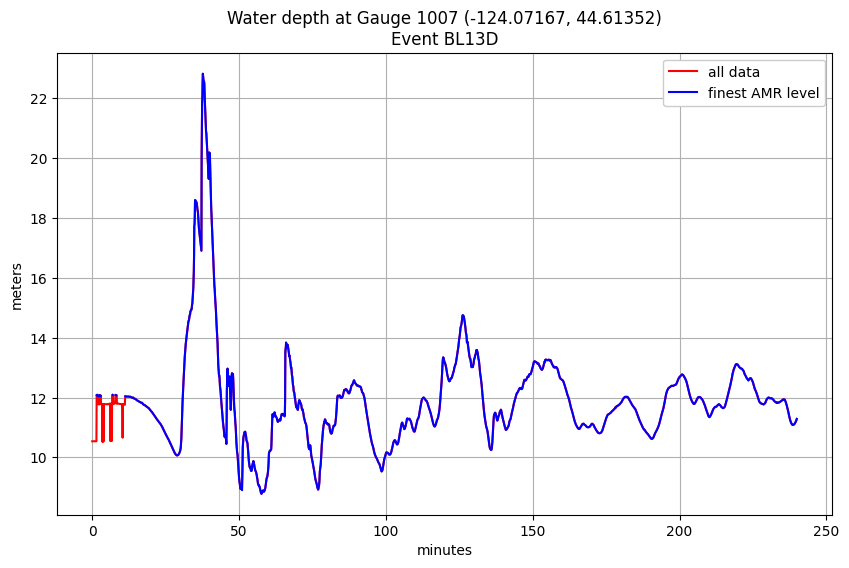

In [19]:
hfine = ds.hfine.sel(gaugeno=mygaugeno, event=myevent)
h = ds.h.sel(gaugeno=mygaugeno, event=myevent)
figure(figsize=(10,6))
tminutes = gauge_t / 60.
    
plot(tminutes, h, 'r',label='all data')
plot(tminutes, hfine, 'b',label='finest AMR level')

grid(True)
legend(loc='upper right', framealpha=1)
xlabel('minutes')
ylabel('meters')
title('Water depth at Gauge %i (%.5f, %.5f)\nEvent %s' % (mygaugeno,xg,yg,myevent));

## Plot all events at one gauge

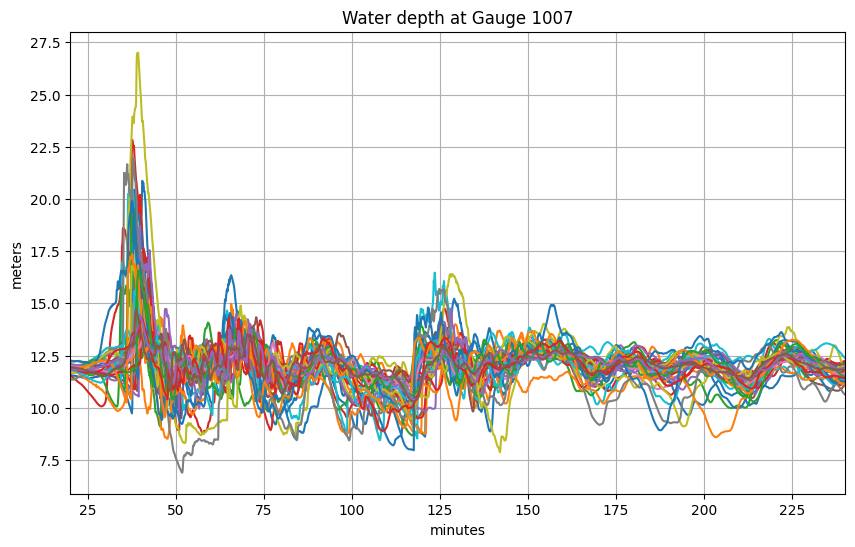

In [20]:
events = ds.coords['event'].data  # all events
hfine_all = ds.hfine.sel(gaugeno=mygaugeno, event=events)

figure(figsize=(10,6))
for ev in events:
    plot(tminutes, hfine_all.sel(event=ev), label=ev)
# legend()  # not very useful with 36 events
grid(True)
xlim(20,4*60)
xlabel('minutes')
ylabel('meters')
title('Water depth at Gauge %s' % mygaugeno);

### What's the maximum value at this gauge over all events, and which event is largest?

From the plot above it's hard to tell which event corresponds to the upper-most curve, so let's look at the maximum depth at this gauge for each event:

In [21]:
print('The maximum depth over all time for all events is %.2f meters' % hfine_all.max())

The maximum depth over all time for all events is 27.00 meters


We can plot the maximum depth for each event separately:

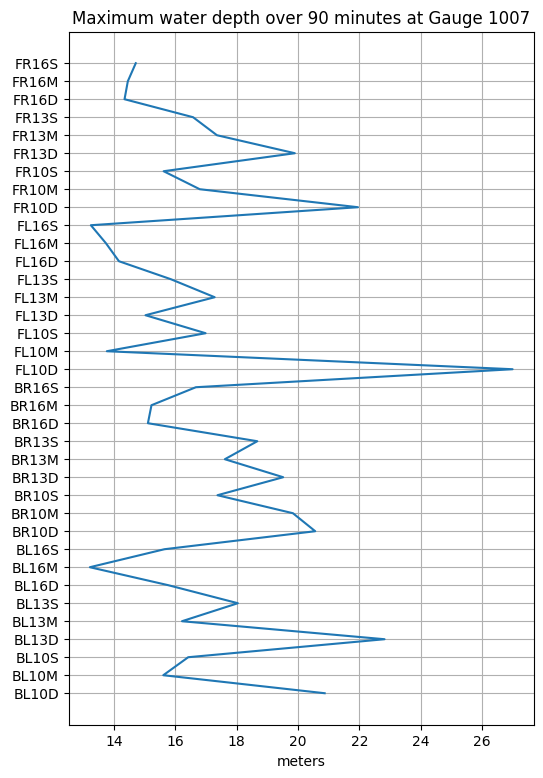

In [22]:
hmax = hfine_all.max(dim='time')  # 1D array of 36 values for each event

figure(figsize=(6,9))
ievents = range(len(hmax.coords['event']))
plot(hmax.data, ievents)
yticks(ievents, hmax.coords['event'].data);
grid(True)
xlabel('meters')
title('Maximum water depth over 90 minutes at Gauge %i' % mygaugeno);

A more programatic way to determine which event has this maximum value is to use `argmax`:

In [23]:
imax = int(hmax.argmax(dim='event'))
emax = events[imax]
hmax = float(ds.h.sel(event=emax, gaugeno=mygaugeno).max())
print(f'Event {imax} named {emax} has the largest maximum depth at Gauge {mygaugeno} with value {hmax:.2f} m')

Event 18 named FL10D has the largest maximum depth at Gauge 1007 with value 27.00 m


### Plot this largest event to confirm:

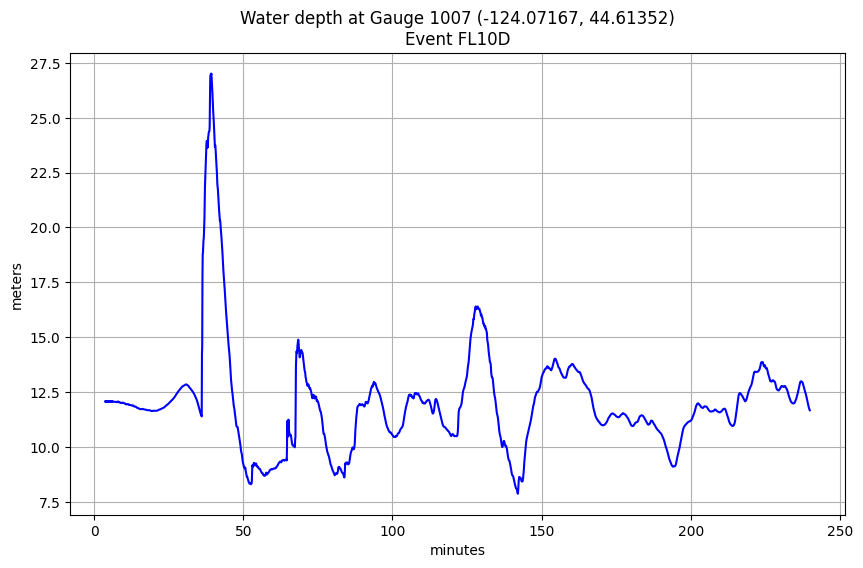

In [24]:
figure(figsize=(10,6))
tminutes = gauge_t / 60.
plot(tminutes, hfine_all.sel(event=emax), 'b')
grid(True)
xlabel('minutes')
ylabel('meters')
title('Water depth at Gauge %i (%.5f, %.5f)\nEvent %s' % (mygaugeno,xg,yg,emax));

## Find maximum event for an onshore gauge:

In [25]:
mygaugeno = 1022
map = folium_plot_gauge(mygaugeno)  #  argument can be single gauge or list of gauges
print(f'Location of Gauge {mygaugeno}:')
map

Location of Gauge 1022:


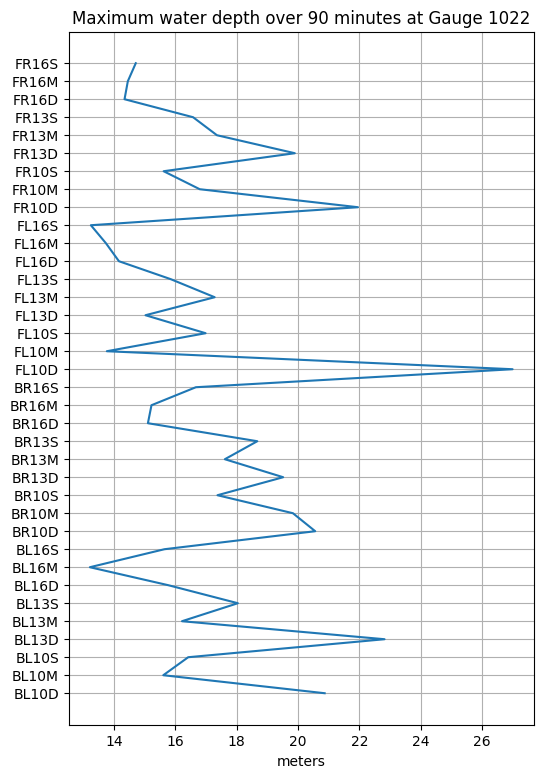

In [26]:
hmax = hfine_all.max(dim='time')  # 1D array of 36 values for each event

figure(figsize=(6,9))
ievents = range(len(hmax.coords['event']))
plot(hmax.data, ievents)
yticks(ievents, hmax.coords['event'].data);
grid(True)
xlabel('meters')
title('Maximum water depth over 90 minutes at Gauge %i' % mygaugeno);

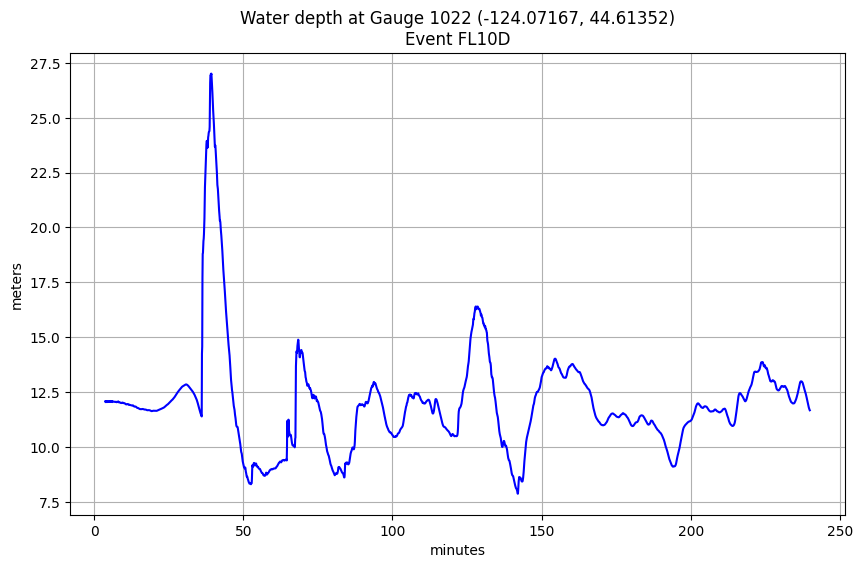

In [27]:
imax = int(hmax.argmax(dim='event'))
emax = events[imax]

figure(figsize=(10,6))
tminutes = gauge_t / 60.
plot(tminutes, hfine_all.sel(event=emax), 'b')
grid(True)
xlabel('minutes')
ylabel('meters')
title('Water depth at Gauge %i (%.5f, %.5f)\nEvent %s' % (mygaugeno,xg,yg,emax));